## Codes taken from appendix of Blakely's textbook, translated from Fortran to Python 

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def dircos(incl,decl,azim):
    '''
    c
    c  Subroutine DIRCOS computes direction cosines from inclination
    c  and declination.
    c
    c  Input parameters:
    c    incl:  inclination in degrees positive below horizontal.  
    c    decl:  declination in degrees positive east of true north.  
    c    azim:  azimuth of x axis in degrees positive east of north.
    c
    c  Output parameters:
    c    a,b,c:  the three direction cosines.
    c
    '''
    d2rad = .017453293
    xincl=incl*d2rad
    xdecl=decl*d2rad
    xazim=azim*d2rad 
    a=np.cos(xincl)*np.cos(xdecl-xazim)
    b=np.cos(xincl)*np.sin(xdecl-xazim)
    c=np.sin(xincl)

    return a,b,c

    
    
def mbox(x0,y0,z0,x1,y1,z1,x2,y2,mi,md,fi,fd,m,theta):
    '''
    c
    c  Subroutine MBOX computes the total field anomaly of an infinitely 
    c  extended rectangular prism.  Sides of prism are parallel to x,y,z 
    c  axes, and z is vertical down.  Bottom of prism extends to infinity.
    c  Two calls to mbox can provide the anomaly of a prism with finite 
    c  thickness; e.g., 
    c
    c     call mbox(x0,y0,z0,x1,y1,z1,x2,y2,mi,md,fi,fd,m,theta,t1)
    c     call mbox(x0,y0,z0,x1,y1,z2,x2,y2,mi,md,fi,fd,m,theta,t2)
    c     t=t1-t2
    c
    c  Requires subroutine DIRCOS.  Method from Bhattacharyya (1964).
    c
    c  Input parameters:
    c    Observation point is (x0,y0,z0).  Prism extends from x1 to 
    c    x2, y1 to y2, and z1 to infinity in x, y, and z directions, 
    c    respectively.  Magnetization defined by inclination mi, 
    c    declination md, intensity m.  Ambient field defined by 
    c    inclination fi and declination fd.  X axis has declination 
    c    theta. Distance units are irrelevant but must be consistent.  
    c    Angles are in degrees, with inclinations positive below 
    c    horizontal and declinations positive east of true north.
    c    Magnetization in A/m.
    c
    c  Output paramters:
    c    Total field anomaly t, in nT.
    c
    '''
    alpha = np.zeros((2,))
    beta = np.zeros((2,))
    cm = 1.e-7
    t2nt = 1.e9
    ma,mb,mc = dircos(mi,md,theta)
    fa,fb,fc = dircos(fi,fd,theta)
    fm1=ma*fb+mb*fa
    fm2=ma*fc+mc*fa
    fm3=mb*fc+mc*fb
    fm4=ma*fa
    fm5=mb*fb
    fm6=mc*fc
    alpha[0]=x1-x0
    alpha[1]=x2-x0
    beta[0]=y1-y0
    beta[1]=y2-y0
    h=z1-z0
    t=0.
    hsq=h**2
    for i in [0,1]:
        alphasq=alpha[i]**2
        for j in [0,1]:
            sign=1.
            if i!=j:
                sign = -1.
            r0sq=alphasq+beta[j]**2+hsq
            r0=np.sqrt(r0sq)
            r0h=r0*h
            alphabeta=alpha[i]*beta[j]
            arg1=(r0-alpha[i])/(r0+alpha[i])
            arg2=(r0-beta[j])/(r0+beta[j])
            arg3=alphasq+r0h+hsq
            arg4=r0sq+r0h-alphasq
            tlog=fm3*np.log(arg1)/2.+fm2*np.log(arg2)/2.-fm1*np.log(r0+h)
            tatan=-fm4*np.arctan2(alphabeta,arg3)-fm5*np.arctan2(alphabeta,arg4)+fm6*np.arctan2(alphabeta,r0h)
            t=t+sign*(tlog+tatan)
    t=t*m*cm*t2nt

    return t

## Example application following the analysis of Nimmo (2000)

https://doi.org/10.1130/0091-7613(2000)28%3C391:DIAAPC%3E2.0.CO;2

Computing anomaly for a prism with dimensions analogous to a dyke intrusion on Mars

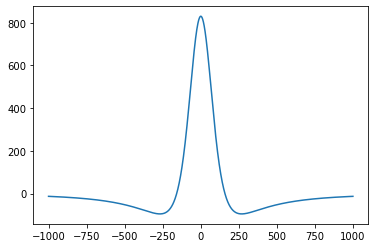

In [82]:
# Values from Nimmo (2000)
obs_x = 0.
obs_y = 0.
obs_z = -100.
x1 = -50.
x2 = 50.
y1 = -1000.
y2 = 1000.
z1 = 5.
mi = 90.
md = 0.
fi = 90.
fd = 0.
m = 10.
theta = 0.

layer_thickness = 100.

profile_X = np.arange(-1000.,1000.,1.)
profile_Z = []
for obs_x in profile_X:
    t1 = mbox(obs_x,obs_y,obs_z,x1,y1,z1,x2,y2,mi,md,fi,fd,m,theta)
    t2 = mbox(obs_x,obs_y,obs_z,x1,y1,z1+layer_thickness,x2,y2,mi,md,fi,fd,m,theta)
    profile_Z.append(t1-t2)
    #profile_Z.append(t1)
    
plt.plot(profile_X,profile_Z)
plt.show()


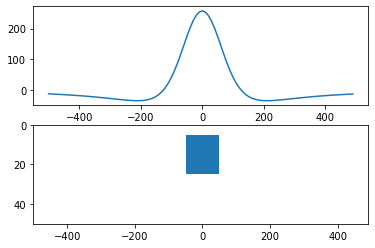

In [83]:
# As above, but defining a function to compute the anomaly

def anomaly_amplitude(layer_thickness, layer_depth, prism_width, magnetisation, 
                      observation_altitude = 100., inclination=90, declination=0):

    obs_x = 0.
    obs_y = 0.
    obs_z = -observation_altitude
    x1 = -prism_width/2.
    x2 = prism_width/2.
    y1 = -1000.
    y2 = 1000.
    z1 = layer_depth
    mi = inclination
    md = declination
    fi = inclination
    fd = declination
    m = magnetisation
    theta = 0.

    profile_X = np.arange(-prism_width*5, prism_width*5, 10.)
    profile_Z = []
    for obs_x in profile_X:
        t1 = mbox(obs_x,obs_y,obs_z,x1,y1,z1,x2,y2,mi,md,fi,fd,m,theta)
        t2 = mbox(obs_x,obs_y,obs_z,x1,y1,z1+layer_thickness,x2,y2,mi,md,fi,fd,m,theta)
        profile_Z.append(t1-t2)
        #profile_Z.append(t1)

    #plt.plot(profile_X,profile_Z)
    
    return (profile_X,profile_Z)
    
layer_thickness=20. 
layer_depth=5. 
prism_width=100
magnetisation=10.
result = anomaly_amplitude(layer_thickness, layer_depth, 
                           prism_width, magnetisation)

plt.subplot(211)
plt.plot(result[0],result[1])

plt.subplot(212)
plt.fill([-prism_width/2.,-prism_width/2.,prism_width/2.,prism_width/2.],
         [layer_depth+layer_thickness,layer_depth,layer_depth,layer_depth+layer_thickness])
plt.xlim(np.min(result[0]), np.max(result[0]))
plt.ylim(50, 0)
plt.show()


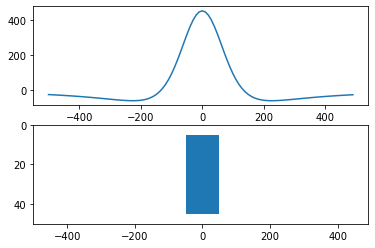

In [84]:
layer_thickness=40. 
result = anomaly_amplitude(layer_thickness, layer_depth, 
                           prism_width, magnetisation)

plt.subplot(211)
plt.plot(result[0],result[1])

plt.subplot(212)
plt.fill([-prism_width/2.,-prism_width/2.,prism_width/2.,prism_width/2.],
         [layer_depth+layer_thickness,layer_depth,layer_depth,layer_depth+layer_thickness])
plt.xlim(np.min(result[0]), np.max(result[0]))
plt.ylim(50, 0)
plt.show()

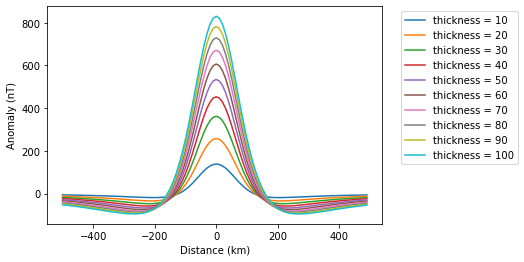

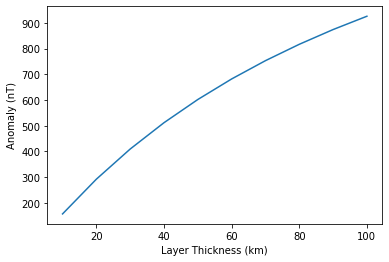

In [85]:
# Example of looping over various layer thicknesses, to get the 

results = []

for layer_thickness in np.arange(10,105,10):
    
    result = anomaly_amplitude(layer_thickness, 5., 100, 10.)
    
    plt.plot(result[0],result[1], label='thickness = {:0.0f}'.format(layer_thickness))
    results.append(np.max(result[1])-np.min(result[1]))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Distance (km)')
plt.ylabel('Anomaly (nT)')
plt.show()
    
plt.plot(np.arange(10,105,10),results)
plt.xlabel('Layer Thickness (km)')
plt.ylabel('Anomaly (nT)')
plt.show()

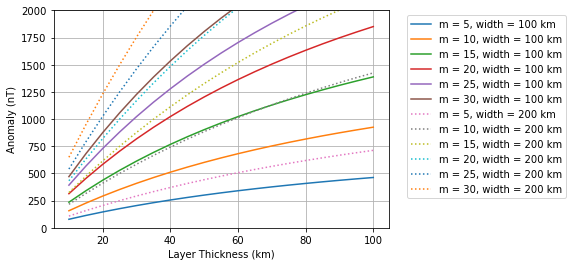

In [86]:
prism_width = 100.
for magnetisation in np.arange(5,31,5):
    results = []
    for layer_thickness in np.arange(10,105,5):

        result = anomaly_amplitude(layer_thickness, 5., prism_width, magnetisation)

        results.append(np.max(result[1])-np.min(result[1]))

    plt.plot(np.arange(10,105,5),results,label='m = {:0.0f}, width = {:0.0f} km'.format(magnetisation,prism_width))

prism_width = 200.
for magnetisation in np.arange(5,31,5):
    results = []
    for layer_thickness in np.arange(10,105,5):

        result = anomaly_amplitude(layer_thickness, 5., prism_width, magnetisation)

        results.append(np.max(result[1])-np.min(result[1]))

    plt.plot(np.arange(10,105,5),results, ':', label='m = {:0.0f}, width = {:0.0f} km'.format(magnetisation,prism_width))
    
plt.ylim(0,2000)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()
plt.xlabel('Layer Thickness (km)')
plt.ylabel('Anomaly (nT)')
plt.show()

## Mars anomaly wavelengths
Now try something relevant to the new problem - if we know the surface magnetic anomaly at two locations ~1,800 km apart, what constraints could this place on the range of permissable magnetisation parameters 

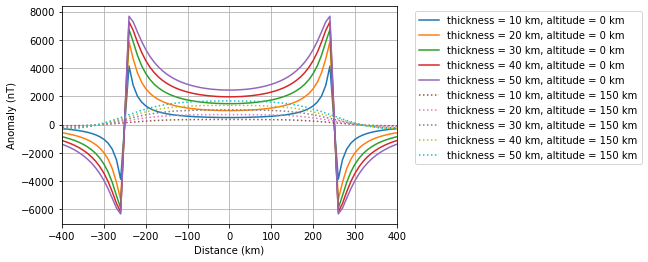

In [98]:
# For various values of layer thickness, compute anomaly profile at two altitudes
# - zero (for surface observation)
# - 200 km (for comparison withe value of Langlais' anomaly map)

prism_width = 500.
layer_depth = 2.
layer_thickness = 20.

observation_altitude = 0.2
results = []
for layer_thickness in np.arange(10,55,10):

    result = anomaly_amplitude(layer_thickness, layer_depth, prism_width, magnetisation, 
                               observation_altitude = observation_altitude)

    results.append(np.max(result[1])-np.min(result[1]))
    plt.plot(result[0],result[1], label='thickness = {:0.0f} km, altitude = {:0.0f} km'.format(layer_thickness, observation_altitude))

#plt.plot(np.arange(5,55,5),results,label='m = {:0.0f}, Altitude = {:0.0f} km'.format(magnetisation,observation_altitude))

observation_altitude = 150.
results = []
for layer_thickness in np.arange(10,55,10):

    result = anomaly_amplitude(layer_thickness, layer_depth, prism_width, magnetisation, 
                               observation_altitude = observation_altitude)

    results.append(np.max(result[1])-np.min(result[1]))
    plt.plot(result[0],result[1], ':', label='thickness = {:0.0f} km, altitude = {:0.0f} km'.format(layer_thickness, observation_altitude))

#plt.plot(np.arange(5,55,5),results, ':', label='m = {:0.0f}, Altitude = {:0.0f} km'.format(magnetisation,observation_altitude))

plt.xlim(-400,400)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()
plt.xlabel('Distance (km)')
plt.ylabel('Anomaly (nT)')
plt.show()

Text(0, 0.5, 'Anomaly (nT)')

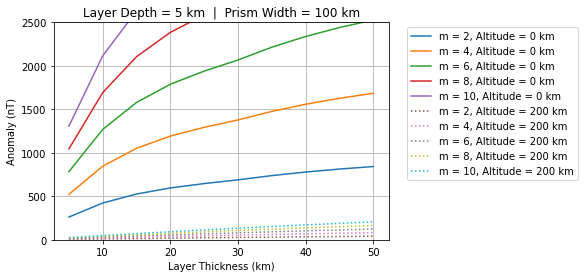

In [80]:
# This figure is an attempt to quantify the peak amplitude for anomalies due to the same body
# at the surface (solid curves) and at satellite altitude (dashed curves), and how this
# varies as a function of prism parameters

prism_width = 100.
layer_depth = 5.

observation_altitude = 0.
for magnetisation in np.arange(2,11,2):
    results = []
    for layer_thickness in np.arange(5,55,5):

        result = anomaly_amplitude(layer_thickness, layer_depth, prism_width, magnetisation, 
                                   observation_altitude = observation_altitude)

        results.append(np.max(result[1])-np.min(result[1]))

    plt.plot(np.arange(5,55,5),results,label='m = {:0.0f}, Altitude = {:0.0f} km'.format(magnetisation,observation_altitude))

observation_altitude = 200.
for magnetisation in np.arange(2,11,2):
    results = []
    for layer_thickness in np.arange(5,55,5):

        result = anomaly_amplitude(layer_thickness, layer_depth, prism_width, magnetisation, 
                                   observation_altitude = observation_altitude)

        results.append(np.max(result[1])-np.min(result[1]))

    plt.plot(np.arange(5,55,5),results, ':', label='m = {:0.0f}, Altitude = {:0.0f} km'.format(magnetisation,observation_altitude))

plt.ylim(0,2500)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()
plt.title('Layer Depth = {:0.0f} km  |  Prism Width = {:0.0f} km'.format(layer_depth, prism_width))
plt.xlabel('Layer Thickness (km)')
plt.ylabel('Anomaly (nT)')

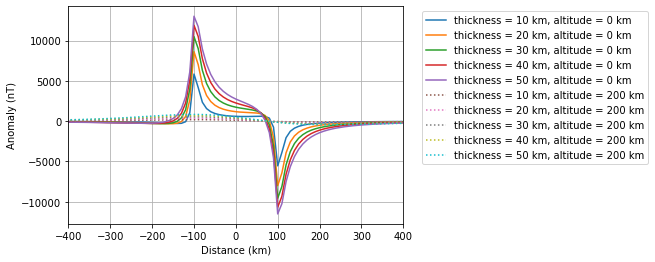

In [90]:
# For various values of layer thickness, compute anomaly profile at two altitudes
# - zero (for surface observation)
# - 200 km (for comparison withe value of Langlais' anomaly map)

prism_width = 200.
layer_depth = 5.
layer_thickness = 20.
inclination = 60.

observation_altitude = 0.
results = []
for layer_thickness in np.arange(10,55,10):

    result = anomaly_amplitude(layer_thickness, layer_depth, prism_width, magnetisation, 
                               observation_altitude = observation_altitude, inclination=inclination)

    results.append(np.max(result[1])-np.min(result[1]))
    plt.plot(result[0],result[1], label='thickness = {:0.0f} km, altitude = {:0.0f} km'.format(layer_thickness, observation_altitude))

#plt.plot(np.arange(5,55,5),results,label='m = {:0.0f}, Altitude = {:0.0f} km'.format(magnetisation,observation_altitude))

observation_altitude = 200.
results = []
for layer_thickness in np.arange(10,55,10):

    result = anomaly_amplitude(layer_thickness, layer_depth, prism_width, magnetisation, 
                               observation_altitude = observation_altitude, inclination=inclination)

    results.append(np.max(result[1])-np.min(result[1]))
    plt.plot(result[0],result[1], ':', label='thickness = {:0.0f} km, altitude = {:0.0f} km'.format(layer_thickness, observation_altitude))

#plt.plot(np.arange(5,55,5),results, ':', label='m = {:0.0f}, Altitude = {:0.0f} km'.format(magnetisation,observation_altitude))

plt.xlim(-400,400)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()
plt.xlabel('Distance (km)')
plt.ylabel('Anomaly (nT)')
plt.show()